# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

For this assignment, you will use reinforcement learning to solve the [Towers of Hanoi](https://en.wikipedia.org/wiki/Tower_of_Hanoi) puzzle with three pegs and five disks.

To accomplish this, you must modify the code discussed in lecture for learning to play Tic-Tac-Toe.  Modify the code  so that it learns to solve the three-disk, three-peg
Towers of Hanoi Puzzle.  In some ways, this will be simpler than the
Tic-Tac-Toe code.  

Steps required to do this include the following:

  - Represent the state, and use it as a tuple as a key to the Q dictionary.
  - Make sure only valid moves are tried from each state.
  - Assign reinforcement of $1$ to each move, even for the move that results in the goal state.

Make a plot of the number of steps required to reach the goal for each
trial.  Each trial starts from the same initial state.  Decay epsilon
as in the Tic-Tac-Toe code.

## Requirements

First, how should we represent the state of this puzzle?  We need to keep track of which disks are on which pegs. Name the disks 1, 2, 3, 4, and 5, with 1 being the smallest disk and 5 being the largest. The set of disks on a peg can be represented as a list of integers.  Then the state can be a list of three lists.

For example, the starting state with all disks being on the left peg would be `[[1, 2, 3, 4, 5], [], []]`.  After moving disk 1 to peg 2, we have `[[2, 3, 4, 5], [1], []]`.

To represent that move we just made, we can use a list of two peg numbers, like `[1, 2]`, representing a move of the top disk on peg 1 to peg 2.

Now on to some functions. Define at least the following functions. Examples showing required output appear below.

   - `print_state(state)`: prints the state in the form shown below
   - `get_valid_moves(state)`: returns list of moves that are valid from `state`
   - `make_move(state, move)`: returns new (copy of) state after move has been applied.
   - `train_Q(n_repetitions, learning_rate, epsilon_decay_factor, get_valid_moves, make_move)`: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of number of steps to reach goal for each repetition.
   - `test_Q(Q, max_steps, get_valid_moves, make_move)`: without updating Q, use Q to find greedy action each step until goal is found. Return path of states.

A function that you might choose to implement is

   - `state_move_tuple(state, move)`: returns tuple of state and move.  
    
This is useful for converting state and move to a key to be used for the Q dictionary.

Show the code and results for testing each function.  Then experiment with various values of `n_repetitions`, `learning_rate`, and `epsilon_decay_factor` to find values that work reasonably well, meaning that eventually the minimum solution path of seven steps is found consistently.

Make a plot of the number of steps in the solution path versus number of repetitions. The plot should clearly show the number of steps in the solution path eventually reaching the minimum of seven steps, though the decrease will not be monotonic.  Also plot a horizontal, dashed line at a height (value on  y axis) of 30 to show the optimal path length.

Use at least a total of 15 sentences to describe the following results:
- Add markdown cells in which you describe the Q learning algorithm and your implementation of Q learning as applied to the Towers of Hanoi problem.
- Add code cells to examine several Q values from the start state with different moves and discuss if the Q values  make sense. 
- Also add code cells to examine several Q values from one or two states that are two steps away from the goal and discuss if these Q values make sense.

In [1]:
import copy
def print_state(state):
    print_string = ""
    #need to use deepcopy to avoid modifying original state
    filler_state = copy.deepcopy(state)
    #pad out each entry in state with spaces so all the lists are the same length
    for i in range(len(filler_state)):
        if len(filler_state[i]) < 5:
            for j in range(5-len(filler_state[i])):
                #print("filler state before")
                filler_state[i].insert(0, " ")
    #put together the return string taking the ith index of every list for each column
    for i in range(5):
        for j in range(len(filler_state)):
            print_string += str(filler_state[j][i]) + " "
        print_string += "\n"
    print_string += "------"
    print(print_string)

In [2]:
def get_valid_moves(state):
    moves = []
    for i in range(len(state)):
        for j in range(len(state)):
            #if there are no disks on current the peg do nothing
            if len(state[i]) == 0:
                pass
            #if the target peg has no disks then it is a valid move
            elif len(state[j]) == 0:
                moves.append([i+1,j+1])
            #if the top disk on the current peg is less than the top disk of the target peg it is a valid move
            elif state[i][0] < state[j][0]:
                moves.append([i+1,j+1])
    return moves

In [3]:
def make_move(state, move):
    state_copy = state.copy()
    #assuming all moves passed to function are valid, and it is by human indices (0->1)
    state_copy[move[1]-1].insert(0, state_copy[move[0]-1].pop(0))
    return state_copy

In [4]:
#convenience function for converting state and move to a formatted tuple
def state_move_tuple(state, move):
    return (tuple([tuple(ele) for ele in state]), tuple(move))

In [5]:
import numpy as np

#epsilonGreedy adapted from lecture notes 15
def epsilonGreedy(epsilon, Q, board):
    validMoves = get_valid_moves(board)
    if np.random.uniform() < epsilon:
        #random move
        return validMoves[np.random.choice(len(validMoves))]
    else:
        #greedy move
        Qs = np.array([Q.get(state_move_tuple(board, m), 0) for m in validMoves])
        #using argmin here instead of argmax because we are solving towers of hanoi and trying to minimize
        return validMoves[ np.argmin(Qs) ]

#train_Q adapted from lecture notes 15
def train_Q(n_repetitions, learning_rate, epsilon_decay_factor, get_valid_moves, make_move):
    #goal is to move all pegs to the right peg/3rd peg
    Q = {} #empty table
    # list of steps taken in each repetition
    steps = []
    #initial epsilon is 1
    epsilon = 1.0
    #iterate n_repetition times
    for repetition in range(n_repetitions):
        #each repetition decays epsilon
        epsilon *= epsilon_decay_factor
        step = 0
        #start state is all disks in order on the left peg
        board = [[1, 2, 3, 4, 5], [], []]
        #boolean tracker for if the goal is found
        done = False
        
        while not done:
            #increment number of steps taken
            step += 1
            #each step make a move chosen using epsilonGreedy
            move = epsilonGreedy(epsilon, Q, board)
            #use deepcopy to utilize a copy without affecting the original
            boardNew = copy.deepcopy(board)
            boardNew = make_move(boardNew, move)
            
            if state_move_tuple(board, move) not in Q:
                #initial Q value for new board,move is 0, will grow over time
                Q[state_move_tuple(board, move)] = 0
            #if all disks are in the correct order on the right peg then we won!
            if boardNew == [[],[],[1,2,3,4,5]]:
                #assign a reinforcement value of 1 even for reaching the goal (as per the instructions)
                Q[state_move_tuple(board, move)] = 1
                #since we reached the goal we are done with this repetition
                done = True
                #log the number of steps taken this repetition and append it to the list
                steps.append(step)
            if step > 1:
                #recalculate Q value
                Q[state_move_tuple(boardOld, moveOld)] += learning_rate * (1+ Q[state_move_tuple(board, move)] - Q[state_move_tuple(boardOld, moveOld)])
            #switch out the previous board and move for the next ones
            boardOld, moveOld = board, move
            board = boardNew
    #return the Q values and the number of steps taken for each repetition
    return Q, steps

In [6]:
def test_Q(Q, max_steps, get_valid_moves, make_move):
    board = [[1, 2, 3, 4, 5], [], []]
    path = []
    #start logging the path taken
    path.append(board)
    #track number of steps and check they are below max_steps
    num_steps = 0
    #make moves until the goal is found or we take too long (num_steps >= max_steps)
    while board != [[],[],[1,2,3,4,5]] and num_steps < max_steps:
        #now that our Q values have been trained we just take the greedy move every move
        validMoves = get_valid_moves(board)
        Qs = np.array([Q.get(state_move_tuple(board, m), 0) for m in validMoves])
        board = copy.deepcopy(make_move(board, validMoves[ np.argmin(Qs) ]))
        path.append(board)
        num_steps+=1
    #some weird adjustments required for the path
    path.insert(0, [[1, 2, 3, 4, 5], [], []])
    del path[len(path)-1]
    return path

# Examples

In [7]:
state = [[1, 2, 3, 4, 5], [], []]
print_state(state)

1     
2     
3     
4     
5     
------


In [8]:
move =[1, 2]  # Move top (smallest) disk from first peg to second peg
state_move_tuple(state, move)

(((1, 2, 3, 4, 5), (), ()), (1, 2))

In [9]:
new_state = make_move(state, move)
new_state

[[2, 3, 4, 5], [1], []]

In [10]:
get_valid_moves(new_state)

[[1, 3], [2, 1], [2, 3]]

In [11]:
print_state(new_state)

      
2     
3     
4     
5 1   
------


In [12]:
Q, steps_to_goal = train_Q(200, 0.5, 0.7, get_valid_moves, make_move)

In [13]:
steps_to_goal

[1720,
 478,
 690,
 1426,
 1651,
 754,
 273,
 334,
 571,
 194,
 489,
 357,
 188,
 141,
 291,
 215,
 160,
 756,
 366,
 570,
 177,
 367,
 344,
 155,
 450,
 234,
 102,
 297,
 532,
 140,
 199,
 347,
 205,
 323,
 166,
 422,
 168,
 128,
 177,
 348,
 111,
 439,
 136,
 150,
 187,
 135,
 121,
 111,
 181,
 106,
 352,
 64,
 99,
 234,
 114,
 188,
 113,
 283,
 346,
 55,
 61,
 327,
 101,
 128,
 430,
 69,
 73,
 117,
 106,
 131,
 51,
 190,
 79,
 216,
 65,
 78,
 40,
 76,
 271,
 80,
 89,
 172,
 103,
 248,
 343,
 51,
 157,
 50,
 109,
 94,
 43,
 40,
 205,
 51,
 53,
 210,
 66,
 82,
 113,
 41,
 92,
 44,
 42,
 157,
 51,
 237,
 59,
 65,
 38,
 49,
 89,
 174,
 69,
 61,
 47,
 185,
 41,
 49,
 31,
 66,
 142,
 54,
 33,
 38,
 48,
 35,
 83,
 139,
 33,
 68,
 38,
 35,
 34,
 244,
 34,
 47,
 36,
 121,
 33,
 31,
 33,
 74,
 79,
 32,
 31,
 34,
 31,
 33,
 31,
 32,
 31,
 39,
 31,
 31,
 31,
 147,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 3

In [14]:
path = test_Q(Q, 100, get_valid_moves, make_move)

In [15]:
path

[[[1, 2, 3, 4, 5], [], []],
 [[2, 3, 4, 5], [], [1]],
 [[3, 4, 5], [2], [1]],
 [[3, 4, 5], [1, 2], []],
 [[4, 5], [1, 2], [3]],
 [[1, 4, 5], [2], [3]],
 [[1, 4, 5], [], [2, 3]],
 [[4, 5], [], [1, 2, 3]],
 [[5], [4], [1, 2, 3]],
 [[5], [1, 4], [2, 3]],
 [[2, 5], [1, 4], [3]],
 [[1, 2, 5], [4], [3]],
 [[1, 2, 5], [3, 4], []],
 [[2, 5], [3, 4], [1]],
 [[5], [2, 3, 4], [1]],
 [[5], [1, 2, 3, 4], []],
 [[], [1, 2, 3, 4], [5]],
 [[1], [2, 3, 4], [5]],
 [[1], [3, 4], [2, 5]],
 [[], [3, 4], [1, 2, 5]],
 [[3], [4], [1, 2, 5]],
 [[3], [1, 4], [2, 5]],
 [[2, 3], [1, 4], [5]],
 [[1, 2, 3], [4], [5]],
 [[1, 2, 3], [], [4, 5]],
 [[2, 3], [], [1, 4, 5]],
 [[3], [2], [1, 4, 5]],
 [[3], [1, 2], [4, 5]],
 [[], [1, 2], [3, 4, 5]],
 [[1], [2], [3, 4, 5]],
 [[1], [], [2, 3, 4, 5]],
 [[], [], [1, 2, 3, 4, 5]]]

In [16]:
for s in path:
    print_state(s)
    print()

1     
2     
3     
4     
5     
------

      
2     
3     
4     
5   1 
------

      
      
3     
4     
5 2 1 
------

      
      
3     
4 1   
5 2   
------

      
      
      
4 1   
5 2 3 
------

      
      
1     
4     
5 2 3 
------

      
      
1     
4   2 
5   3 
------

      
      
    1 
4   2 
5   3 
------

      
      
    1 
    2 
5 4 3 
------

      
      
      
  1 2 
5 4 3 
------

      
      
      
2 1   
5 4 3 
------

      
      
1     
2     
5 4 3 
------

      
      
1     
2 3   
5 4   
------

      
      
      
2 3   
5 4 1 
------

      
      
  2   
  3   
5 4 1 
------

      
  1   
  2   
  3   
5 4   
------

      
  1   
  2   
  3   
  4 5 
------

      
      
  2   
  3   
1 4 5 
------

      
      
      
  3 2 
1 4 5 
------

      
      
    1 
  3 2 
  4 5 
------

      
      
    1 
    2 
3 4 5 
------

      
      
      
  1 2 
3 4 5 
------

      
      
      
2 1   
3 4 5 
------

      
    

Text(0.5, 0, 'Number of repetitions')

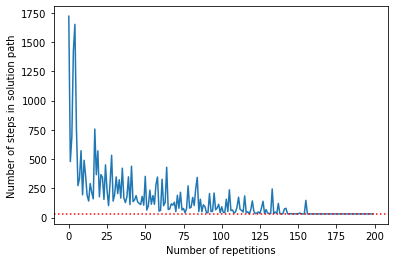

In [18]:
import matplotlib.pyplot as plt
plt.plot(steps_to_goal)
plt.axhline(y=31, color='r', ls=':')
plt.ylabel('Number of steps in solution path')
plt.xlabel('Number of repetitions')

# Discussion Part 1: Plot of the results

The plot of the number of steps in the solution path versus the number of repetitions is available directly above. The red dashed line is y=31, indicating the minimum number of steps in the solution path.

# Discussion Part 2: Description of the Q learning algorithm and implementation

This implementation of Q learning algorithm seeks to represent the (state, move) tuples in this problem with a discrete value.  This value can be called the reinforcement value, temporal difference value or Q value.  This value should represent the estimate of the return of making the given move at the given state.  In this instance, states and moves nearer to the goal should have reinforcement values closer to 1 than those further away from the goal.  In the Towers of Hanoi problem I implemented, the start state was all the disks in order on the leftmost peg, and the goal state was all the disks in order of the rightmost peg.  In this implementation each move made was based on the epsilon-greedy policy, as seen in lecture 15.  In the epsilon-greedy policy, each repetition of finding the goal decreased a value epsilon by a certain amount (the epsilon decay factor).  This value epsilon is what controlled the policy for making moves: at higher epsilon values the policy would be more likely to choose a random move, and once lower epsilon values were reached (at higher repetition counts) the policy would be more likely to choose to make greedy moves.  The greedy-style moves relied on the reinforcement value stored: if a greedy move was performed, it would choose the move with the lowest reinforcement value, which in this case, would (hopefully) be closer to the goal.  This policy works to fill in the reinforcement values for new (state, move) tuples towards the beginning by choosing randomly and eventually fine-tune those values towards their correct values as time goes on and more greedy moves are chosen.  Eventually, once epsilon became low enough, greedy moves were chosen more often.  At this point the reinforcement values for the (state, move) tuples were were accurate enough to give the correct move towards the goal consistently.  As such, as seen in the graph above, the number of steps taken to reach the goal trended downward as the reinforcement values were filled in over time and greedy moves were chosen more often.  As is noted in the code cells above, my train_Q function was adapted from lecture notes 15.  

In [47]:
#discussion part 3
q_state = [[1,2,3,4,5],[],[]]
print("State:")
print_state(q_state)
print("Move: (1,2)")
print("Q value:",Q[(((1, 2, 3, 4, 5), (), ()), (1, 2))])

q_state = [[1,2,3,4,5],[],[]]
print("\nState:")
print_state(q_state)
print("Move: (1,3)")
print("Q value:",Q[(((1, 2, 3, 4, 5), (), ()), (1, 3))])

q_state = [[2,3,4,5],[],[1]]
print("\nState:")
print_state(q_state)
print("Move: (1,2)")
print("Q value:",Q[(((2, 3, 4, 5), (), (1,)), (1, 2))])

q_state = [[2,3,4,5],[],[1]]
print("\nState:")
print_state(q_state)
print("Move: (3,1)")
print("Q value:",Q[(((2, 3, 4, 5), (), (1,)), (3, 1))])

q_state = [[2,3,4,5],[],[1]]
print("\nState:")
print_state(q_state)
print("Move: (3,2)")
print("Q value:",Q[(((2, 3, 4, 5), (), (1,)), (3, 2))])

State:
1     
2     
3     
4     
5     
------
Move: (1,2)
Q value: 31.049352734685833

State:
1     
2     
3     
4     
5     
------
Move: (1,3)
Q value: 31.0

State:
      
2     
3     
4     
5   1 
------
Move: (1,2)
Q value: 30.0

State:
      
2     
3     
4     
5   1 
------
Move: (3,1)
Q value: 30.06180577122334

State:
      
2     
3     
4     
5   1 
------
Move: (3,2)
Q value: 30.28776853909548


# Discussion Part 3: Examination of start state code cells

Above is a representation of the state, move, and corresponding Q value of some of the starting and adjacent states.  It can be seen that the (state, move) pairs which bring the state closer to the goal have a lower Q value.  In particular the (state, move) pairs which correspond to the path found by test_Q have Q values equal to 32-s, with s being the number of the step in the path.  In the cases shown, it is the move with the lowest Q value per state that is shown in the path, as expected.  This is because the path was generated using the test_Q function, which always uses the greedy policy of always choosing the lowest Q value.  

In [52]:
#discussion part 4
q_state = [[1],[2],[3,4,5]]
print("State:")
print_state(q_state)
print("Move: (1,2)")
print("Q value:",Q[(((1,), (2,), (3, 4, 5)), (1, 2))])

q_state = [[1],[2],[3,4,5]]
print("\nState:")
print_state(q_state)
print("Move: (2,3)")
print("Q value:",Q[(((1,), (2,), (3, 4, 5)), (2, 3))])

#print all of Q
#num = dict(sorted(Q.items(), key=lambda x: x[1]))
#for k,v in num.items():
#    print(k,v)

State:
      
      
    3 
    4 
1 2 5 
------
Move: (1,2)
Q value: 2.375

State:
      
      
    3 
    4 
1 2 5 
------
Move: (2,3)
Q value: 2.0


# Discussion Part 4: Examination of near-goal state code cells

Above is the representation of the state, move and corresponding Q value of states that are 2 steps away from the goal.  As expected, it can be seen that the move with the lower Q value of 2.0 is the one that leads to the board that is one move away from the goal.  

## Grading

Download and extract `A4grader.py` from [A4grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A4grader.tar).

In [19]:
%run -i A4grader.py


======================= Code Execution =======================

['Valdes-A4.ipynb']
Extracting python code from notebook named 'Valdes-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

  state = [[1], [2,3], [4, 5]]
  moves = get_valid_moves(state)


--- 5/5 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing

    state = [[], [], [1, 2, 3, 4, 5]]
    moves = get_valid_moves(state)


--- 5/5 points. Correctly returned [[3, 1], [3, 2]]

Testing

    state = [[], [], [1, 2, 3, 4, 5]]
    new_state = make_move(state, [3, 1])


--- 5/5 points. Correctly returned [[1], [], [2, 3, 4, 5]]

Testing

    state = [[1, 2], [3], [4, 5]]
    new_state = make_move(state, [1, 3])


--- 5/5 points. Correctly returned [[2], [3], [1, 4, 5]]

Testing

    Q, steps = train_Q(1000, 0.5, 0.7, get_valid_moves, make_move)


--- 10/10 points. Correctly returned list of steps that has 1000 elements.

--- 10/10 points. C

## Extra Credit

Modify your code to solve the Towers of Hanoi puzzle with four pegs and five disks.  Name your functions

    - print_state_4pegs
    - get_valid_moves_4pegs
    - make_move_4pegs

Find values for number of repetitions, learning rate, and epsilon decay factor for which train_Q learns a Q function that test_Q can use to find the shortest solution path.  Include the output from the successful calls to train_Q and test_Q.